<h1 align="center">Housing & the Financial Crisis: The Impact of Real Estate on Bank Failure</h3> 

<h3 align="center">William Bradley, Nick Heitzman, Brad Kelly</h3> 
<h3 align="center">May 2nd, 2015</h3> 


###Objective

The objective of this research is analyze the relationship between the housing market and bank failures. We hope to identify specific asset compositions which lend themselves to having an increased risk of failure during a given economic climate.

### Hypotheses

1) US Banks with total assets under $1 billion are more susceptible to failure in a macroeconomic environment in which the US housing market experiences deflation. 

2) US Banks who are overinvested in real estate will see an increased chance of failure in a period of housing market deflation.

3) We will observe a lag in housing market changes and investment decisions and their impact on bank failure. We do not expect changes in a housing index or investment decisions to cause banks to immediately fail.


###Description of Data Sources Used in Analysis

The data model of our PostegreSQL database contained 8 tables. This database was hosted on Amazon Web Services. These tables are referred to in various Psycopg2 queries.
* **Bank_Ratios**: This is the main data table which contains all banks that file call reports with the Fed. Each bank reported quarterly, and provided various ratios which were used in analysis. Data in this table begins in 2002 and ends in 2014. Our analysis is limited to the population of banks represented in the Federal Financial Institutions Examination Council Uniform Bank Performance Reports.
* **Concentrations of Credit**: Additional statistics for banks filing call reports. Data in this table was less complete than Bank Ratios.
* **LU_Bank**: This table contains the list and descriptive statistics of failed banks. This table also identifies when a specific bank closed; and if it was acquired, who the acquiring institution was.
* **LU_Bank_Detailed**: This table contains all banks which file call reports with the Fed, regardless of failure status.
* **Case_Shiller**: National Housing Index. Provides index values by month.
* **Housing_Index_FM_State**: Freddie Mac Housing Index information provided at the state level.


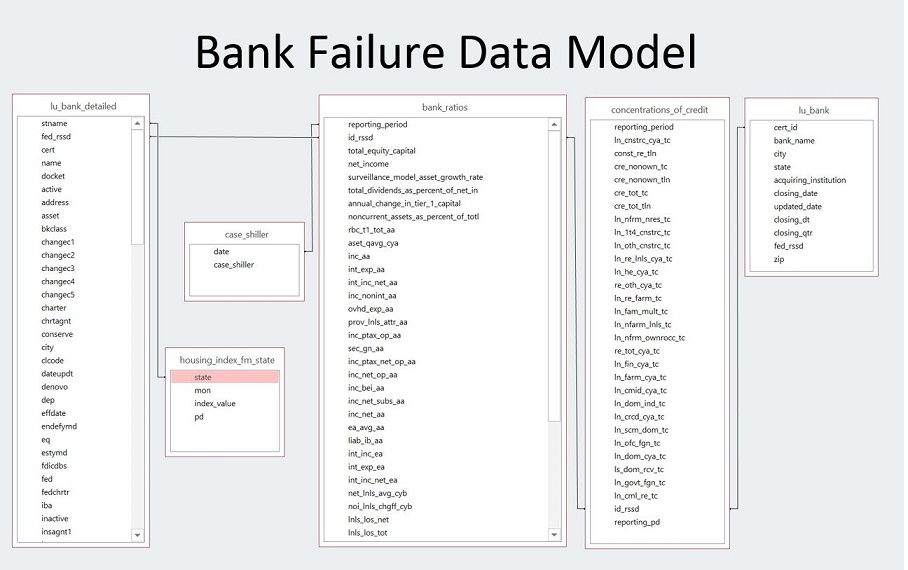

In [2]:
Data_Model

### Data Wrangling and Data Munging

In [1]:
#Import Commands
import psycopg2 as psql
import sys
import pandas as pd
import numpy as np

The Uniform Bank Performance Report data was separated into 12 different files. The first step in wrangling our data sources is concatenating all of the reports into a single Pandas DataFrame which was exported to our database via CSV file. This data can be found at https://cdr.ffiec.gov/public/

In [2]:
#Append all UBPR Reports into a single dataframe
def combine_fed_data():
    
    years = range(2002, 2015)
    pieces = []

    # Loop UBPR files on disk
    for year in years:
        path = 'FFIEC CDR UBPR Ratios Summary Ratios %d.txt' % year
        frame = pd.read_csv(path, delimiter = '\t', header=True)

        pieces.append(frame)
    # Concatenate into single data frame

    data_initial = pd.concat(pieces)
    data = data_initial.rename(columns = {'Unnamed: 0': 'Reporting_Period', 'Unnamed: 1': 'ID_RSSD'})
    
    return data

The Case Shiller index data was imported straight into our PostegreSQL database. Since this data was at the month level and our Bank Ratios data was at the quarter level, we used p-SQL to create a closing must have a similar date key so we converted the dates into "Closing Quarters" using the following PostegreSQL script:

    update lu_bank set closing_qtr = to_date((date_part('year', closing_dt)::text || '-' || 
    case when (date_part('quarter', closing_dt)*3)= 12  then 12::text 
    else '0' ||date_part('quarter', closing_dt)*3 end::text  || '-' 
    || case when date_part('quarter', closing_dt) = 3 or case when date_part('quarter', closing_dt) = 12 
    then 31 else 30 end::text),'yyyy-mm-dd'); 

To analyze lags in Freddie Mac State data, we used the following pSQL query to create lag columns.

    select a.pd::date, a.index_value::float, a.state::text, b.fed_rssd::int, c.index_value::float as 
    index_value_two_year_lag,  d.index_value::float as index_value_one_year_lag 
    from hpi_freddie_state a 
    inner join lu_bank_detailed b on a.state::text = b.stalp::text 
    inner join (select c.pd + interval '2 years' as pd, c.index_value, c.state from hpi_freddie_state c) c 
    on c.pd = a.pd and c.state = a.state 
    inner join (select d.pd + interval '1 years' as pd, d.index_value, d.state from hpi_freddie_state d) d 
    on d.pd = a.pd and d.state = a.state 

####Obtain Data from pSQL Database

In [3]:
#Connect to Database
conn = psql.connect(conn_string)
cursor = conn.cursor()

In [4]:
##Fetch Case Shiller Data from pSQL
strSQL = """select a.pd, (a.case_shiller::float) as cs_index_cur, (b.case_shiller::float) as cs_index_two_lag,
            (c.case_shiller::float) as cs_index_one_lag
            from case_shiller a
            inner join 
                (select (pd + interval '2 years')::date as pd, b.case_shiller 
                from case_shiller b) b 
            on a.pd = b.pd
            inner join 
                 (select (pd + interval '1 years')::date as pd, c.case_shiller 
                from case_shiller c) c
            on a.pd = c.pd"""

cursor.execute(strSQL)
cs_data = cursor.fetchall()
cs_df = pd.DataFrame(cs_data,columns = ['pd', 'cs_index_cur', 'cs_index_two_lag', 'cs_index_one_lag'])


In [5]:
#Fetch FM Housing Data
cursor.execute("""select pd::date, index_value::float, state::text, fed_rssd::int, index_two_year_lag::float, index_one_year_lag::float
                   from housing_index_fm_state""")
fm_st_data = cursor.fetchall()
fm_df = pd.DataFrame(fm_st_data, columns=['pd', 'fm_index_value', 'state', 'fed_rssd', 'fm_index_two_year_lag', 'fm_index_one_year_lag'])

In [6]:
#Fetch Bank Ratios Data
cursor.execute("""select a.id_rssd::int, a.reporting_pd::date, aset_qavg_cya::float, 
                    lnls_tot_pd_90_grs::float, ln_re_lnls_cya_tc::float,  
                    d.closing_date::date - interval '90 days', re_tot_cya_tc::float, 
                    risk_based_cap::float, treasuries_pct_of_sec::float,
                    muni_pct_of_sec::float, pass_thru_mbs::float,cmo_remic_mbs::float,
                    const_re_tln::float, ln_he_cya_tc::float
                    from bank_ratios a 
                    left join concentrations_of_credit b on a.id_rssd::int = b.id_rssd::int 
                        and a.reporting_pd::date = b.reporting_pd::date
                    left join lu_bank d on a.id_rssd::int = d.fed_rssd::int""")

br_data = cursor.fetchall()
br_df = pd.DataFrame(br_data, columns=['id', 'reporting_pd', 'average_assets', 'delinquent_loans', 
                                       'residential_loan_pct', 'closing_date', 'real_estate_loan_pct', 
                                       'risk_based_cap', 'treasury_sec', 'muni_sec', 'mbs_sec', 'cmo_remic_sec',
                                       'const_land_dev_rbc_pct', 'heloc_rbc_pct' ])


In [7]:
#Fetch Bank Ratios One Year Lag
cursor.execute("""select a.id_rssd::int, a.reporting_pd::date + interval '1 year', aset_qavg_cya::float, 
                    lnls_tot_pd_90_grs::float, ln_re_lnls_cya_tc::float,  
                    d.closing_date::date - interval '90 days', re_tot_cya_tc::float,
                    risk_based_cap::float,treasuries_pct_of_sec::float,
                    muni_pct_of_sec::float, pass_thru_mbs::float,cmo_remic_mbs::float,
                    const_re_tln::float, ln_he_cya_tc::float
                    from bank_ratios a 
                    left join concentrations_of_credit b on a.id_rssd::int = b.id_rssd::int 
                        and a.reporting_pd::date = b.reporting_pd::date
                    left join lu_bank d on a.id_rssd::int = d.fed_rssd::int""")

br_data_lag = cursor.fetchall()
br_df_lag = pd.DataFrame(br_data_lag, columns=['id', 'reporting_pd', 'average_assets_one_lag', 
                                       'delinquent_loans_one_lag', 'residential_loan_pct_one_lag',
                                       'closing_date_one_lag', 'real_estate_loan_pct_one_lag',
                                       'risk_based_cap_one_lag','treasury_sec_one_lag', 
                                       'muni_sec_one_lag', 'mbs_sec_one_lag', 'cmo_remic_sec_one_lag',
                                       'const_land_dev_rbc_pct_one_lag', 'heloc_rbc_pct_one_lag'])


In [8]:
#Fetch Bank Ratios Two Year Lag
cursor.execute("""select a.id_rssd::int, a.reporting_pd::date + interval '2 year', aset_qavg_cya::float, 
                    lnls_tot_pd_90_grs::float, ln_re_lnls_cya_tc::float,  
                    d.closing_date::date - interval '90 days', re_tot_cya_tc::float,
                    risk_based_cap::float,treasuries_pct_of_sec::float,
                    muni_pct_of_sec::float, pass_thru_mbs::float,cmo_remic_mbs::float,
                    const_re_tln::float, ln_he_cya_tc::float
                    from bank_ratios a 
                    left join concentrations_of_credit b on a.id_rssd::int = b.id_rssd::int 
                        and a.reporting_pd::date = b.reporting_pd::date
                    left join lu_bank d on a.id_rssd::int = d.fed_rssd::int""")

br_data_lag2 = cursor.fetchall()
br_df_lag2 = pd.DataFrame(br_data_lag2, columns=['id', 'reporting_pd', 'average_assets_two_lag', 
                                                 'delinquent_loans_two_lag', 'residential_loan_pct_two_lag', 
                                                 'closing_date_two_lag', 'real_estate_loan_pct_two_lag',
                                                 'risk_based_cap_two_lag','treasury_sec_two_lag', 
                                                 'muni_sec_two_lag', 'mbs_sec_two_lag', 'cmo_remic_sec_two_lag',
                                                 'const_land_dev_rbc_pct_two_lag', 'heloc_rbc_pct_two_lag'])


####Conversion and Validation of Data Types

In [9]:
br_df.closing_date = pd.to_datetime(br_df.closing_date)
br_df.reporting_pd = pd.to_datetime(br_df.reporting_pd)
br_df_lag.closing_date_one_lag = pd.to_datetime(br_df_lag.closing_date_one_lag)
br_df_lag.reporting_pd = pd.to_datetime(br_df_lag.reporting_pd)
cs_df.pd = pd.to_datetime(cs_df.pd)
fm_df.pd = pd.to_datetime(fm_df.pd)

####Assign Flags and Lag Fields for Modeling and Analysis

For our analysis, we will set flags to identify <br>
* Banks which fail at some point in time (failed_ind)
* Banks which are in their last quarter of solvency (failed_qtr)


In [10]:
#Idennify if bank is part of the failed bank population
br_df['failed_ind'] = np.where(br_df['closing_date'] > 1 ,1,0)

In [11]:
#Identify if bank failed in the given period
br_df['failed_qtr'] = np.where((br_df['reporting_pd'] >= br_df['closing_date']) & (br_df['closing_date']>0),1.0,0.0)

Our third hypothesis indicates we will observe a delay in increased bank failures when the housing market declines. To account for this, we created percent change variables in both the Case Shiller Index and the Freddie Mac State index. We analyze the percent change for both one and two year lags, as it is unclear which lag will be most predictive.

In [12]:
#Identify percent change in two year lag for Case Shiller Index
cs_df['cs_two_lag_pct_change'] = (cs_df['cs_index_cur'] - cs_df['cs_index_two_lag'])/ cs_df['cs_index_two_lag']
cs_df['cs_one_lag_pct_change'] = (cs_df['cs_index_cur'] - cs_df['cs_index_one_lag'])/ cs_df['cs_index_one_lag']

In [13]:
#Identify state percent change
fm_df['fm_state_two_lag_pct_change'] = (fm_df['fm_index_value'] - fm_df['fm_index_two_year_lag']) / fm_df['fm_index_two_year_lag']
fm_df['fm_state_one_lag_pct_change'] = (fm_df['fm_index_value'] - fm_df['fm_index_one_year_lag']) / fm_df['fm_index_one_year_lag']

####Merge Data Frames for Modeling and Analysis

To create one table for modeling and analysis, we merged our Bank Ratios, Bank Ratios One Year Lag, Bank Ratios Two Year Lag, Case Shiller, and Freddie Mac State index into one pandas data frame.

In [14]:
df = pd.merge(br_df, cs_df, left_on='reporting_pd', right_on= 'pd', how='inner')
df = pd.merge(df, fm_df, left_on = ['reporting_pd', 'id'] , right_on = ['pd','fed_rssd'], how = 'left')
df = pd.merge(df, br_df_lag, left_on=['reporting_pd', 'id'], right_on = ['reporting_pd', 'id'], how = 'inner')
df = pd.merge(df, br_df_lag2, left_on=['reporting_pd', 'id'], right_on = ['reporting_pd', 'id'], how = 'inner')

The closing date columns are no longer needed once the Failed Quarter and Failed Indicator flags have been set.

In [15]:
#Drop Closing Dates
df = df.drop('closing_date',1)
df = df.drop('closing_date_two_lag',1)
df = df.drop('closing_date_one_lag',1)


##Exploratory Data Analysis

Our hypothesis predicted banks which were overinvested in real estate would have a much better chance of failing when deflation in the housing market occurs. We also hypothesized that banks with an average_assets under $1 billion would have a much greater chance of failure during times of economic uncertainty. <br>

The failed indicator (1 = Failure, 0 = Non-Failure) divides those banks which failed during the examined time period. As predicted, the loan portfolio of banks which would go on to fail were more invested in real estate than banks which did not fail, and the average assets of banks which did not fail was roughly four times larger than those which would go on to fail. 

In [16]:
by_fail = df.groupby(['failed_ind'])
by_fail['average_assets', 'real_estate_loan_pct'].mean()

,average_assets,real_estate_loan_pct
failed_ind,,
0,2369806.896973,427.595743
1,584512.165294,835.183360


After analyzing the basic profile of failed and non-failed banks, we tested statistical significance of our variables.

In [17]:
df['failed_qtr'].corr(df['cs_two_lag_pct_change'])

-0.034738396269561038

In [18]:
df['failed_qtr'].corr(df['fm_state_two_lag_pct_change'])

-0.048472602123997739

In [19]:
df['failed_ind'].corr(df['real_estate_loan_pct_two_lag'])

0.13425664994052786

In [20]:
df['failed_ind'].corr(df['average_assets_two_lag'])

-0.0078201557551236742

As the correlation values indicate, there was no statistical correlation between the variables we thought would predict failure. This is most likely due to the extremely low rate of bank failure in the US. Our population contains four records per year for each bank while it is a solvent entity. Roughly 4.5% of the banks in our population failed, and failure from a data perspective only occurs in a single quarter for each failing bank. We attempted a logistic regression, and it confirmed the lack of statistical significance  in our variables.

## Machine Learning

###Model Selection and Objective

Since our regression analysis did not show any of our variables to have a strong relationship to our bank failure identifier, we pursued an alternative, and ideally predictive, method for analyzing this relationship.  By utilizing a decision tree model, our team is hoping to create a model, capable of machine-learning, where trends and patterns in our data set may identify potential sources of risk that ultimately lead to bank failures.

The objective of our model is to identify circumstances which will cause banks to have a much higher chance of failure in a given quarter. Approximately 4.5% of the banks in the population examined failed; however, each bank had a record for every quarter in which it was a solvent entity. To evaluate success of a decision tree, we cannot measure against the 4.5% of banks that failed, we must measure against the total failing quarters as a percentage of total instances in our dataset. 

In [21]:
df.failed_qtr.sum()/df.id.nunique()

0.04765419082762256

In [22]:
df.failed_qtr.sum() / (df.id.count() + .000)

0.0015302063408771604

Our population indicates that in a given quarter, 0.15% of previously solvent banks will fail; thus, success of our decision tree would be any circumstance where the chance of failure is significantly greater than 0.15%.

###Feature Selection

Prior to running our decision tree model, we analyze the fit and relevance for each of our potential variables. We started by analyzing our main ratio, real_estate_loan_pct. 

In [23]:
by_failure = df.groupby(['failed_qtr'])
by_failure[['real_estate_loan_pct_two_lag','real_estate_loan_pct_one_lag','real_estate_loan_pct']].mean()

,real_estate_loan_pct_two_lag,real_estate_loan_pct_one_lag,real_estate_loan_pct
failed_qtr,,,
0,423.470230,430.908160,437.913444
1,704.453928,904.245038,2627.204017


The column real_estate_loan_pct is the sum of real estate loans as a percentage of risk based capital. We noticed very extreme spikes between the years leading up to failure. As the chart below demonstrates, this was not due to an increase in real estate lending in the last year of solvency; rather it was due to a sharp decline in risk based capital.

In [24]:
by_failure[['risk_based_cap_two_lag', 'risk_based_cap_one_lag', 'risk_based_cap']].mean()

,risk_based_cap_two_lag,risk_based_cap_one_lag,risk_based_cap
failed_qtr,,,
0,193208.402702,212963.993504,232778.041030
1,62747.190265,55817.077434,18483.267699


In [25]:
by_failure[['average_assets_two_lag', 'average_assets_one_lag', 'average_assets']].mean()

,average_assets_two_lag,average_assets_one_lag,average_assets
failed_qtr,,,
0,1943929.534961,2130942.832889,2312561.949864
1,648402.548286,688084.447471,651418.622049


While banks tend to exhaust liquidity reserves prior to failure, their average assets are a much more stable value. We transformed each of our variables which were a percentage of risk based capital, and made them a percentage of average assets (or average assets lag for that specific year). As predicted, this removed the large spikes leading up to the failed period.

In [26]:
df['real_estate_asset_pct'] = (df['real_estate_loan_pct'] * df['risk_based_cap']) / df['average_assets']
df['real_estate_asset_pct_one_lag'] = (df['real_estate_loan_pct_one_lag'] * df['risk_based_cap_one_lag']) / df['average_assets_one_lag']
df['real_estate_asset_pct_two_lag'] = (df['real_estate_loan_pct_two_lag'] * df['risk_based_cap_two_lag']) / df['average_assets_two_lag']
df['risk_based_cap_two_lag_asset_pct'] = (df['risk_based_cap_two_lag'] / df['average_assets'])
df['heloc_asset_pct_two_lag'] = (df['heloc_rbc_pct_two_lag'] * df['risk_based_cap_two_lag']) / df['average_assets_two_lag']
df['heloc_asset_pct_one_lag'] = (df['heloc_rbc_pct_one_lag'] * df['risk_based_cap_one_lag']) / df['average_assets_one_lag']
df['heloc_asset_pct'] = (df['heloc_rbc_pct'] * df['risk_based_cap']) / df['average_assets']
df['const_land_dev_asset_pct_two_lag'] = (df['const_land_dev_rbc_pct_two_lag'] * df['risk_based_cap_two_lag']) / df['average_assets_two_lag']
df['const_land_dev_asset_pct_one_lag'] = (df['const_land_dev_rbc_pct_one_lag'] * df['risk_based_cap_one_lag']) / df['average_assets_one_lag']
df['const_land_dev_asset_pct'] = (df['const_land_dev_rbc_pct'] * df['risk_based_cap']) / df['average_assets']
df['log_assets'] = np.log(df['average_assets_two_lag'])

In [27]:
by_failure[['real_estate_asset_pct_two_lag','real_estate_asset_pct_one_lag','real_estate_asset_pct']].mean()

,real_estate_asset_pct_two_lag,real_estate_asset_pct_one_lag,real_estate_asset_pct
failed_qtr,,,
0,44.780248,45.145302,45.269827
1,64.612115,60.902242,55.145691


In [28]:
by_failure[['mbs_sec_two_lag','mbs_sec_one_lag','mbs_sec']].mean()

,mbs_sec_two_lag,mbs_sec_one_lag,mbs_sec
failed_qtr,,,
0,21.489640,21.934999,22.365785
1,28.175673,30.480006,31.258323


In [29]:
by_failure[['const_land_dev_asset_pct_two_lag','const_land_dev_asset_pct_one_lag','const_land_dev_asset_pct']].mean()

,const_land_dev_asset_pct_two_lag,const_land_dev_asset_pct_one_lag,const_land_dev_asset_pct
failed_qtr,,,
0,1.043379,0.925314,0.881092
1,3.083556,2.067936,0.364711


###Feature Definitions

* fm_state_two_lag_pct_change: The percentage change in value of the Freddie Mac State Housing index from two years prior to the observed period.
* cs_two_lag_pct_change: The percentage change in value of the Case Shiller index from two years prior to the observed period.
* const_land_dev_asset_pct: Construction and land development loans as a percentage of total assets.
* real_estate_asset_pct: All real estate loans as a percentage of total assets.
* muni_sec: Municipal bonds as a percentage of total securities.
* log_assets: The natural log of average assets from the period two years prior to the observed reporting period.
* cmo_remic_sec: Collateralized mortgage obligation as a percentage of total securities.
* heloc_asset_pct: Home equity line of credit as a percentage of total assets.
* treasury_sec: Treasury securities as a percentage of total securities.
* mbs_sec: Mortgage backed securities as a percentage of total securities.
* delinquent_loans: Sum of loans past due at least 90 days as a percentage of gross loans.
* risk_based_cap: Risk based capital.
* residential_loan_pct: One to four family residential loans as a percentage of risk based capital.
* two_lag (suffix): This suffix is applied to all variables which indicate the value two years prior to the observed period. 
* one_lag (suffix): Two Lag (suffix): this suffix is applied to all variables which indicate the value two years prior to the observed period. 


###Logit Regression

Our group pursued a logit and probit model for analyzing the influences and probability of bank failure in our data set.  In this set, of nearly 300,000 observations and spanning 10 years, we engineered a dummy variable for bank failure (0 if in business, 1 if failed), and analyzed this against a series of financial and macroeconomic variables.  Both the logit and probit model show the statistical significance of risk-based capital, but only as a percentage of assets.  In other words, banks were roughly 34% less likely to fail if they had a higher capital coverage for their assets.  Additionally, average asset size and risk based capital alone had the weakest significance in our entire data set. This leads us to reaffirm that bank failure is caused by risks that are not necessarily determined by the size of the bank, and that bank failure is less likely to occur if the amount of risk based capital a bank has is weighted by the size of its assets. 

In [30]:
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
import csv
import pandas as pd

features = df.columns - ['failed_ind','failed_qtr']

x = df[features]
y = df['failed_ind']

lpm_mod = sm.OLS(y, x)
lpm_res = lpm_mod.fit()
print('Parameters: ', lpm_res.params[:-1])

logit_mod = sm.Logit(y, x)
logit_res = logit_mod.fit(disp=0)
print('Parameters: ', logit_res.params)

margeff = logit_res.get_margeff()
print(margeff.summary())

print(logit_res.summary())

probit_mod = sm.Probit(y, x)
probit_res = probit_mod.fit()
probit_margeff = probit_res.get_margeff()
print('Parameters: ', probit_res.params)
print('Marginal effects: ')
print(probit_margeff.summary())

Parameters:  average_assets_two_lag             -1.137215e-10
cmo_remic_sec_two_lag              -4.074534e-04
const_land_dev_asset_pct_two_lag   -2.428716e-04
const_land_dev_rbc_pct_two_lag      4.245301e-03
cs_index_two_lag                    8.076852e-04
cs_two_lag_pct_change               1.081082e-01
delinquent_loans_two_lag            3.691941e-03
heloc_asset_pct_two_lag             1.291044e-03
heloc_rbc_pct_two_lag              -4.262836e-05
log_assets                         -9.105165e-03
mbs_sec_two_lag                    -4.343344e-04
muni_sec_two_lag                   -8.235079e-04
real_estate_asset_pct_two_lag       3.958492e-04
real_estate_loan_pct_two_lag        7.861515e-05
residential_loan_pct_two_lag       -1.166134e-04
risk_based_cap_two_lag              2.095830e-09
risk_based_cap_two_lag_asset_pct   -3.978096e-02
dtype: float64
Parameters:  average_assets_two_lag             -1.121766e-09
cmo_remic_sec_two_lag              -1.023930e-02
const_land_dev_asset_pct_two

###Decision Tree Modeling

We ran multiple iterations of our decision tree, and the two year lag was much more predictive. For our final decision tree model, we chose all two year lag variables.  Our decision tree model will indicate which features are most indicative of bank failure in our dataset.  It will also create a visualization of our tree and provide thresholds which will help us identify high risk of failure. 

In [1]:
from sklearn import tree
from sklearn.externals.six import StringIO  
import pandas as pd
from sklearn.preprocessing import Imputer
import numpy as np
from sklearn.cross_validation import train_test_split
import pydot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

data = df

#Select target variable
Y = data.failed_qtr

cols = ['cs_two_lag_pct_change',  'fm_state_two_lag_pct_change', 'delinquent_loans_two_lag', 
        'residential_loan_pct_two_lag', 'treasury_sec_two_lag', 'muni_sec_two_lag', 
        'mbs_sec_two_lag', 'cmo_remic_sec_two_lag', 'real_estate_asset_pct_two_lag', 
        'log_assets', 'heloc_asset_pct_two_lag', 'const_land_dev_asset_pct_two_lag']

X_initial = data.ix[:, cols]

#Impute mean values in order to return valid results

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_initial)
X = imp.transform(X_initial)

dtree = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_leaf = 250)

#Print shape of features and target
print X.shape
print Y.shape

dtree = dtree.fit(X, Y)

#Print Importance Scores of Each Feature
print pd.DataFrame(sorted(zip(map(lambda x: round(x, 5), dtree.feature_importances_), cols), 
                          reverse=True))

##Create decision tree graph
dot_data = StringIO()
tree.export_graphviz(dtree, out_file=dot_data, feature_names = cols)
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf('data.pdf')

(295385L, 12L)
(295385L,)
          0                                 1
0   0.30360  const_land_dev_asset_pct_two_lag
1   0.27582       fm_state_two_lag_pct_change
2   0.17545                        log_assets
3   0.15618     real_estate_asset_pct_two_lag
4   0.03623           heloc_asset_pct_two_lag
5   0.01883                   mbs_sec_two_lag
6   0.01816             cmo_remic_sec_two_lag
7   0.00607          delinquent_loans_two_lag
8   0.00584             cs_two_lag_pct_change
9   0.00381      residential_loan_pct_two_lag
10  0.00000              treasury_sec_two_lag
11  0.00000                  muni_sec_two_lag


The decision tree identifies risk splitters within our data and identifies high risk combinations of features that led banks on the path to failure.  The complete tree can be found at: https://www.dropbox.com/s/9x8nkbd9ht40kw3/Bank%20Failure%20Decision%20Tree.pdf?dl=0

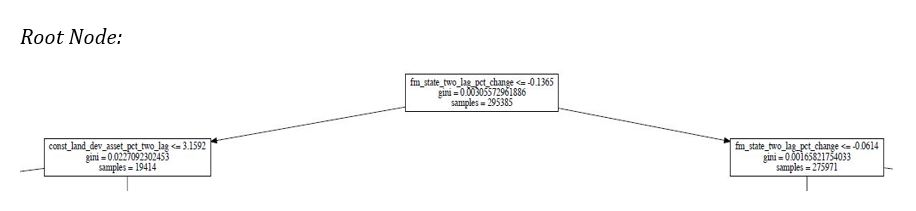

In [2]:
Root_Node

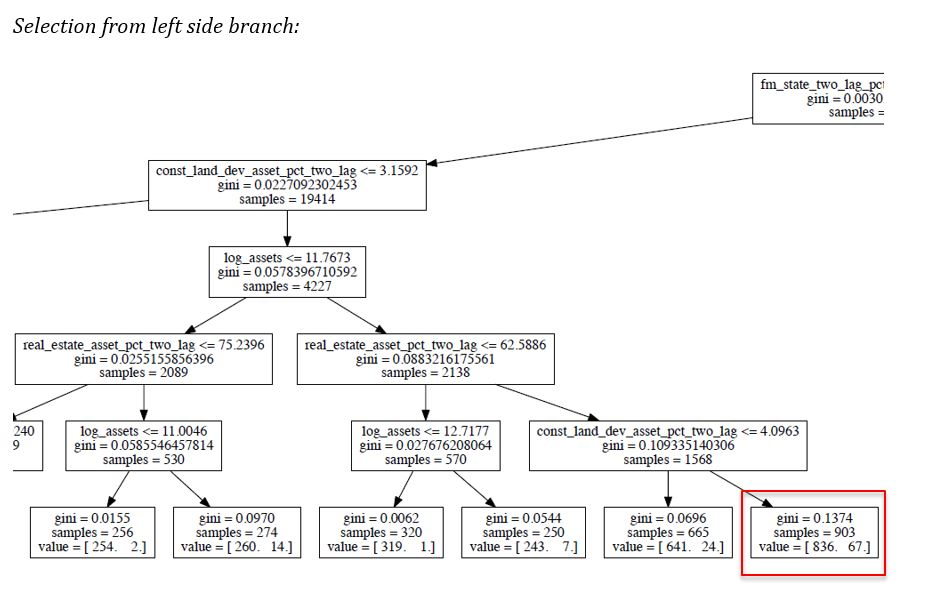

In [4]:
High_Risk_Branch

####Analysis of Model Results

On the left branch of our decision tree, we identified a scenario in which led to a bank failure rate of 8.01%. The thresholds for this category were (all features are two year lags):

* Percent change in Freddie Mac Housing Index <= -13.65% 
* Construction and land development loans as a percentage of total assets > 4.10%
* Real estate loans as a percentage of total assets > 62.58%
* Average assets two year lag >= $129,965,473 

This branch makes up a small part of the total population of bank instances. When a bank measures its risk of failure, they would want to consider only ratios in which they could directly control. These would be 

* Construction and land development loans as a percentage of total assets
* Real estate loans as a percentage of total assets
* Average assets

To examine the population which made up our high risk zone, we only considered these three factors. 

In [8]:
dtree_df = data[['id', 'reporting_pd', 'state', 'const_land_dev_asset_pct_two_lag', 'real_estate_asset_pct_two_lag', 'log_assets', 'fm_state_two_lag_pct_change']]  
dtree_df = dtree_df[(dtree_df.const_land_dev_asset_pct_two_lag > 4.0963) &  
         (dtree_df.real_estate_asset_pct_two_lag > 62.5886) & 
         (dtree_df.log_assets > 11.7673)]
by_state = dtree_df.groupby(['state'])
by_pd = dtree_df.groupby(['reporting_pd'])

by_state_df = pd.DataFrame(by_state['id'].count())
by_pd_df = pd.DataFrame(by_pd['reporting_pd'].count())


When aggregating by reporting period, there appears to be a strong relationship between the instances of banks within the high risk zone and banks that failed during the same time frame. Additionally, the geographical distribution of bank failures was strongly correlated with the geographical distribution of instances of banks in the high risk zone. Specifically, we noticed Georgia and Florida had the most instances in the high risk zone and also had the most failures. Which leads us to believe that the decision tree's predictive methodology can be a useful means for analyzing risks.  

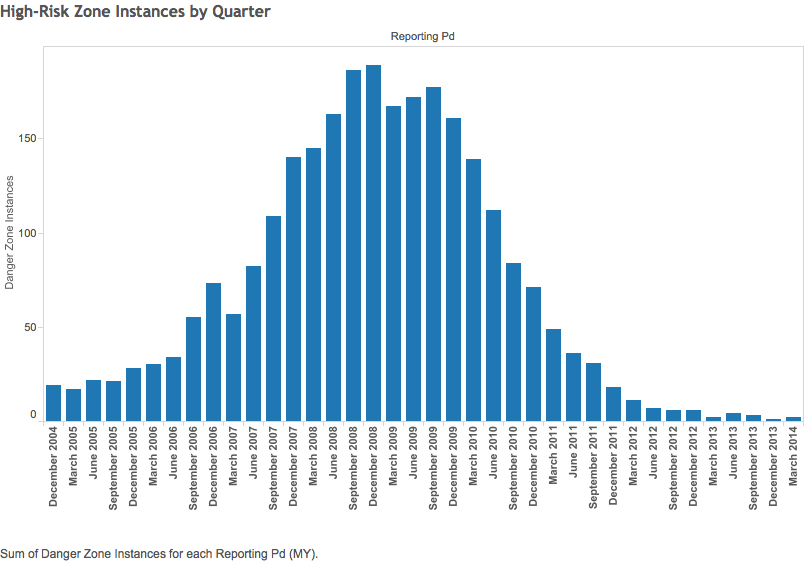

In [6]:
High_Risk_Histogram

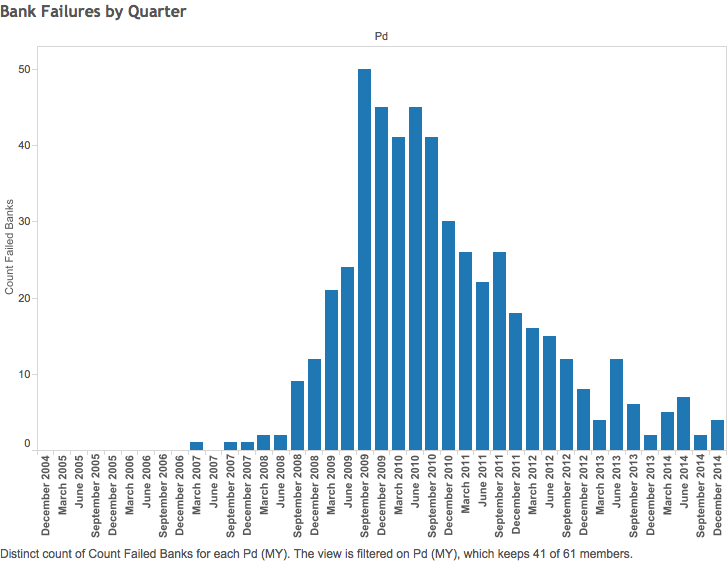

In [8]:
Bank_Failure_Histogram

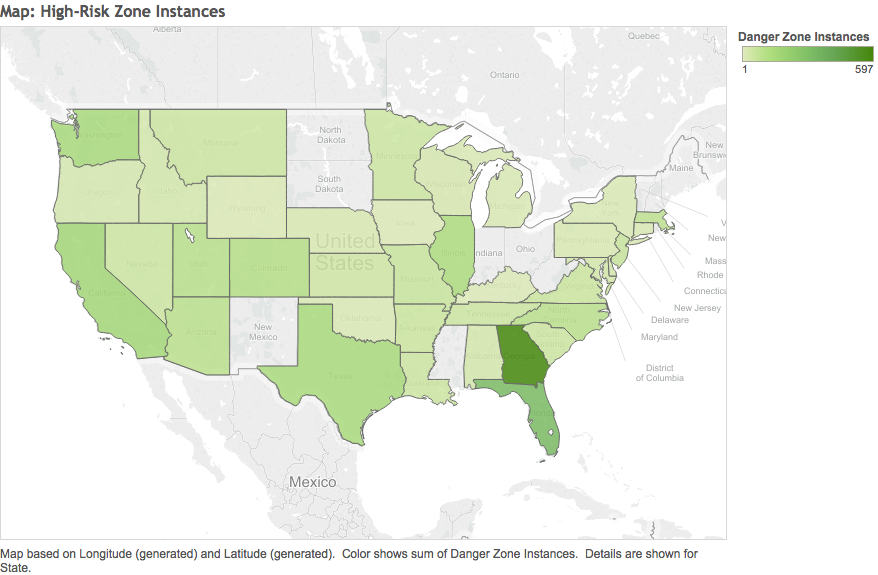

In [10]:
High_Risk_Map

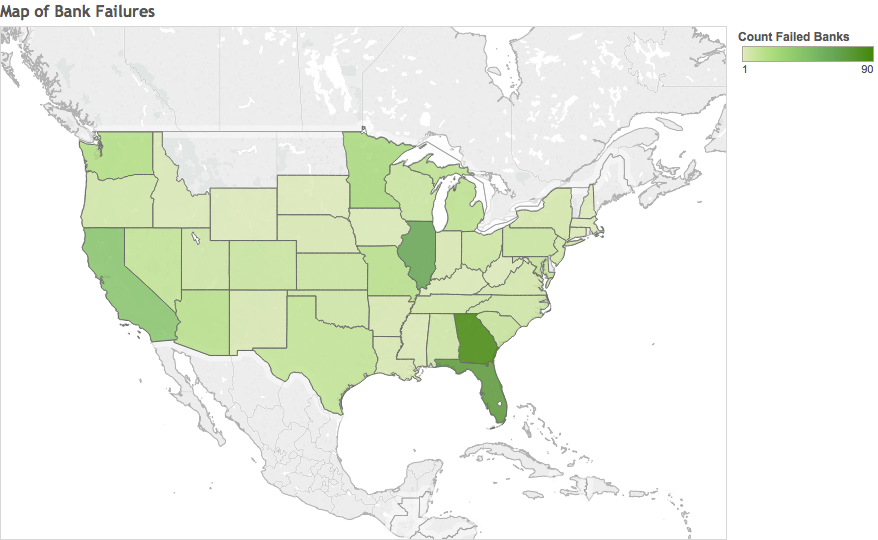

In [12]:
Map_of_Bank_Failures

##Conclusion

Our regression analysis did not reveal a substantial relationship between our financial variables and bank failures, however a number of insights were still garnered by the models. Admittedly, the model reveals the difficulty of sourcing data itself, particularly from the shadow banking sector and other unregulated institutions that sell loans and other risky assets into the regulated banking sector.  Other challenges arise from the nature of the financial variables, which may display co-linearity during an economic downturn, since a bank’s businesses are often exposed to cyclical trends. The lack of frequency for bank failures during the time span of our data also creates a historical bias within the data that makes it more difficult to assess causal factors.  
 
The decision tree, however, is able to identify high-risk scenarios, which have a much greater chance of observing bank failure.  The decision tree analysis demonstrates there are a number of scenarios which lead banks to having a much higher than normal probability of failure.  The risk relationships that are revealed through decision tree analysis provide a strong insight on how fluctuations in housing prices can increase the risks posed by a bank’s exposure from a given allocation in its loan portfolio.  This leads us to believe that a decision tree model may be a reasonable means for analyzing risks across multiple loan categories on a bank’s balance sheet over time.   
 
Another area of further research is additional feature engineering that is needed to create variables that are more accurate in harmonizing data across the banking sector.  The heterogeneous nature of banks and the variety of non-quantifiable factors that could lead to a bank’s failure also poses the challenge of creating more nuanced indicators that can take into account local economic, geographical, and managerial factors that impact a bank’s performance and the timing of failures.
 
In addition to the need for new variables and measurements of bank performance, we believe that more predictive insights should be incorporated into other common measures for predicting bankruptcy, such as the Altman Z-score.  Adjusting either the weights or the ratios of this metric to tailor its use to specific liabilities or assets on the bank’s balance sheet could be a more meaningful means of measuring bankruptcy risk. 
 
In a world of increasing financial innovation and differing financial entities, particularly in the shadow-banking sector, we can conclude that improvements need to be made throughout the data analysis process, with new metrics and methodologies employed to analyze risks and prevent failures within the banking sector.  This need is all the more important since our models suggest that bank failure is driven less by the microeconomics and idiosyncrasies of banks themselves, and more by the macroeconomic trends and cyclical behaviors of the markets – local, regional, or national – they operate within.  




###Additional Modeling Efforts

####Random Forest

The Random Forest Classifier was used to see if we can predict failure within a test sample.

In [77]:
from sklearn.ensemble import RandomForestClassifier

Y = data.failed_qtr

#Split train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=33)

print X_test.shape
print y_test.shape

#Create Random Forest Classifier and predict failures in test set
clf = RandomForestClassifier(n_estimators = 10, criterion='gini', max_depth = None, min_samples_leaf= 250)
clf = clf.fit(X_train, y_train)
scores_rf = cross_val_score(clf, X_train, y_train)
print scores_rf.mean()

ypred = clf.predict(X_test)
print confusion_matrix(y_test, ypred) 
print accuracy_score(y_test, ypred)
print ypred


(73847, 12)
(73847,)
0.998487844133
[[73730     0]
 [  117     0]]
0.998415643154
[ 0.  0.  0. ...,  0.  0.  0.]


The random forest classifier while accurate, never predicts that a bank will fail in our test sample (noted in the confusion matrix) given the limited instances of quarterly failure in our training set.  As evidenced in the decision tree developed earlier, even high risk leaves of the tree are largely outnumbered by surviving banks.  We believe a random forest is still a valid approach to this type of analysis, however it did not yield predictive capabilities in identifying bank failures within our dataset.